In [7]:
################################################################################
# SINGLE-CELL EXAMPLE: PINN TRAINING WITH ALLOW_UNUSED=True
# Fixes the "One of the differentiated Tensors appears to not have been used" error
################################################################################

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

################################################################################
# 1. LOAD AND PREPARE DATA
################################################################################
# Change these paths to match your local files
train_csv = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
test_csv  = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"

# Read CSVs
df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)

# Convert 'time' to datetime
df_train['time'] = pd.to_datetime(df_train['time'])
df_test['time']  = pd.to_datetime(df_test['time'])

# Convert time to numeric (seconds from the start of each dataset)
t0_train = df_train['time'].min()
df_train['time_numeric'] = (df_train['time'] - t0_train).dt.total_seconds()

t0_test = df_test['time'].min()
df_test['time_numeric'] = (df_test['time'] - t0_test).dt.total_seconds()

# Define features and target
features = ['time_numeric','longitude','latitude','elevation','slope_calculated','rainrate']
target   = ['rg_qms']

# Drop rows where features or target are NaN
df_train = df_train.dropna(subset=features + target, how='any')
df_test  = df_test.dropna(subset=features + target, how='any')

# Convert to numpy
X_train = df_train[features].values  # shape [N, 6]
y_train = df_train[target].values    # shape [N, 1]
X_test  = df_test[features].values   # shape [M, 6]
y_test  = df_test[target].values     # shape [M, 1]

# IMPORTANT: If you want partial derivatives wrt time or space,
# set requires_grad=True for those columns at creation.
# For illustration, we set ALL columns to require grad.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_torch = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_torch  = torch.tensor(X_test,  dtype=torch.float32, requires_grad=True).to(device)
y_test_torch  = torch.tensor(y_test,  dtype=torch.float32).to(device)

# Create DataLoaders for mini-batch training
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(X_test_torch, y_test_torch)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

################################################################################
# 2. DEFINE PINN MODEL + SINE ACTIVATION
################################################################################
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, in_features, hidden_dim=128, out_features=1, num_layers=5):
        super(PINN, self).__init__()
        layers = []
        # Input layer
        layers.append(nn.Linear(in_features, hidden_dim))
        layers.append(SineActivation())
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(SineActivation())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, out_features))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

################################################################################
# 3. DEFINE PHYSICS-BASED RESIDUAL (KINEMATIC WAVE EXAMPLE)
# Using allow_unused=True to avoid errors if time/longitude don't affect Q
################################################################################
def kinematic_wave_residual(model, x, c=1.0):
    """
    model: PINN instance
    x: [batch_size, 6], columns = [time_numeric, longitude, latitude, elevation, slope_calculated, rainrate]
    c: wave speed constant (example)
    
    Returns PDE residual shape [batch_size, 1].
    """
    # Separate columns for clarity
    time = x[:, 0:1]  # shape [B, 1]
    lon  = x[:, 1:2]  # shape [B, 1]
    # lat, elevation, slope, etc. could be x[:, 2], x[:, 3], x[:, 4], ...
    
    # Predicted discharge Q
    Q = model(x)  # shape [B, 1]
    
    # partial derivative dQ/dt
    dQ_dt = torch.autograd.grad(
        Q, 
        time,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    # If time doesn't affect Q, dQ_dt could be None. We set it to zero in that case:
    if dQ_dt is None:
        dQ_dt = torch.zeros_like(Q)
    
    # partial derivative dQ/dlon
    dQ_dlon = torch.autograd.grad(
        Q,
        lon,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    if dQ_dlon is None:
        dQ_dlon = torch.zeros_like(Q)
    
    # Suppose R = x[:, 5] is rainrate
    R = x[:, 5:6]  # shape [B, 1]

    # Kinematic wave PDE (simple example): dQ/dt + c * dQ/dlon - R = 0
    residual = dQ_dt + c * dQ_dlon - R
    
    return residual

################################################################################
# 4. TRAINING LOOP
################################################################################

# Hyperparameters
lambda_physics = 0.1
mse_loss = nn.MSELoss()

# Initialize model
model = PINN(in_features=6, hidden_dim=128, out_features=1, num_layers=5).to(device)

# Optimizers
optimizer_adam = optim.Adam(model.parameters(), lr=1e-3)
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=200, history_size=50)

# (Optional) TensorBoard for logging
writer = SummaryWriter(log_dir="./runs/pinn_allow_unused")

num_epochs = 5   # Adam epochs
num_refine = 2   # LBFGS passes
step_counter = 0

# -----------------------------
# PHASE 1: ADAM
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    
    for batch_X, batch_y in train_loader:
        pred_y = model(batch_X)
        loss_data = mse_loss(pred_y, batch_y)
        
        # PDE residual on same batch
        residual = kinematic_wave_residual(model, batch_X)
        loss_physics = torch.mean(residual**2)
        
        loss = loss_data + lambda_physics * loss_physics
        
        optimizer_adam.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer_adam.step()
        
        step_counter += 1
        if step_counter % 10 == 0:
            writer.add_scalar("Train/Loss_Data", loss_data.item(), step_counter)
            writer.add_scalar("Train/Loss_Physics", loss_physics.item(), step_counter)
            writer.add_scalar("Train/Total_Loss", loss.item(), step_counter)
    
    # Evaluate on the entire test set
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_torch)
        test_loss_data = mse_loss(y_test_pred, y_test_torch).item()
        writer.add_scalar("Test/MSE_Data", test_loss_data, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {loss.item():.4f}, "
          f"Test MSE: {test_loss_data:.4f}")

# -----------------------------
# PHASE 2: LBFGS REFINEMENT
# -----------------------------
def closure():
    optimizer_lbfgs.zero_grad()
    pred_y = model(X_train_torch)
    loss_data = mse_loss(pred_y, y_train_torch)
    residual = kinematic_wave_residual(model, X_train_torch)
    loss_physics = torch.mean(residual**2)
    loss_total = loss_data + lambda_physics * loss_physics
    loss_total.backward()
    return loss_total

model.train()
for _ in range(num_refine):
    loss_val = optimizer_lbfgs.step(closure)
    print(f"LBFGS iteration Loss: {loss_val:.4f}")

# Close TensorBoard writer
writer.close()

################################################################################
# 5. EVALUATION METRICS & PREDICTIONS
################################################################################
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_torch)
    test_mse = mse_loss(y_pred_test, y_test_torch).item()
    test_rmse = np.sqrt(test_mse)
    
    # R^2
    ss_res = torch.sum((y_test_torch - y_pred_test)**2)
    ss_tot = torch.sum((y_test_torch - torch.mean(y_test_torch))**2)
    r2 = 1 - ss_res / ss_tot

print(f"\nFinal Test RMSE: {test_rmse:.4f}")
print(f"Final Test R^2:  {r2.item():.4f}")

################################################################################
# 6. SAVE MODEL & QUICK PLOT
################################################################################
torch.save(model.state_dict(), "pinn_model.pt")

plt.figure(figsize=(8,5))
plt.plot(y_test_torch.cpu().numpy(), label='True Discharge')
plt.plot(y_pred_test.cpu().numpy(), label='Predicted Discharge')
plt.xlabel('Sample Index')
plt.ylabel('Discharge (rg_qms)')
plt.legend()
plt.title('PINN Predictions vs. True Discharge')
plt.show()


KeyboardInterrupt: 

In [8]:
import pandas as pd

# Paths to your CSV files
file_2012 = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
file_2013 = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"

def show_file_heads(file_path, num_rows=5):
    """
    Reads the CSV and prints the first few rows (head).
    """
    df = pd.read_csv(file_path)
    print(f"---- HEAD of {file_path} ----")
    print(df.head(num_rows), "\n")

# Show heads of both CSVs
show_file_heads(file_2012, num_rows=5)
show_file_heads(file_2013, num_rows=5)

---- HEAD of /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv ----
                  time  latitude  longitude  rainrate  elevation  \
0  2012-01-01 00:00:00   31.7542    35.3533       0.0  179.91008   
1  2012-01-01 00:00:00   31.7542    35.3639       0.0  182.38225   
2  2012-01-01 00:00:00   31.7542    35.3744       0.0   94.52771   
3  2012-01-01 00:00:00   31.7541    35.3850       0.0  -57.00375   
4  2012-01-01 00:00:00   31.7541    35.3956       0.0   60.18594   

   slope_calculated  rg_qms  
0               NaN     NaN  
1          2.973726     NaN  
2               NaN     NaN  
3               NaN     NaN  
4               NaN     NaN   

---- HEAD of /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.

In [10]:
###############################################################################
# PINN Training with Logging and Time Measurements
# -----------------------------------------------------------------------------
#  1) Loads 2012 (train) and 2013 (test) CSVs.
#  2) Fills missing slope with average slope.
#  3) Splits data into station rows (for data loss) vs collocation rows (for PDE).
#  4) Trains a PINN with both data and physics-based losses, with Adam and LBFGS.
#  5) Uses standard logging for progress info, including time measurements.
###############################################################################
import logging
import time

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

###############################################################################
# LOGGING SETUP
###############################################################################
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

###############################################################################
# 1. LOADING AND PREPROCESSING DATA
###############################################################################
logger.info("Starting data loading and preprocessing...")

train_csv = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
test_csv  = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"

df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)

df_train['time'] = pd.to_datetime(df_train['time'])
df_test['time']  = pd.to_datetime(df_test['time'])

t0_train = df_train['time'].min()
df_train['time_numeric'] = (df_train['time'] - t0_train).dt.total_seconds()

t0_test = df_test['time'].min()
df_test['time_numeric'] = (df_test['time'] - t0_test).dt.total_seconds()

# Fill missing slope with average
mean_slope_train = df_train['slope_calculated'].mean(skipna=True)
df_train['slope_calculated'] = df_train['slope_calculated'].fillna(mean_slope_train)

mean_slope_test = df_test['slope_calculated'].mean(skipna=True)
df_test['slope_calculated']  = df_test['slope_calculated'].fillna(mean_slope_test)

feature_cols = ['time_numeric', 'latitude', 'longitude', 'elevation', 'slope_calculated', 'rainrate']
target_col   = 'rg_qms'

# Split 2012 data: station (rg_qms not NaN) vs collocation (rg_qms NaN)
df_train_station = df_train[~df_train[target_col].isna()].copy()
df_train_colloc  = df_train[df_train[target_col].isna()].copy()

X_train_station = df_train_station[feature_cols].values
y_train_station = df_train_station[[target_col]].values

X_train_colloc = df_train_colloc[feature_cols].values

X_test_all = df_test[feature_cols].values
y_test_all = df_test[[target_col]].values  # might have NaNs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

X_train_station_t = torch.tensor(X_train_station, dtype=torch.float32, requires_grad=True).to(device)
y_train_station_t = torch.tensor(y_train_station, dtype=torch.float32).to(device)

X_train_colloc_t  = torch.tensor(X_train_colloc,  dtype=torch.float32, requires_grad=True).to(device)
X_test_t = torch.tensor(X_test_all, dtype=torch.float32, requires_grad=True).to(device)
y_test_t = torch.tensor(y_test_all, dtype=torch.float32).to(device)

station_dataset = torch.utils.data.TensorDataset(X_train_station_t, y_train_station_t)
station_loader  = torch.utils.data.DataLoader(station_dataset, batch_size=256, shuffle=True)

colloc_dataset  = torch.utils.data.TensorDataset(X_train_colloc_t)
colloc_loader   = torch.utils.data.DataLoader(colloc_dataset, batch_size=256, shuffle=True)

logger.info("Finished data loading and preprocessing.")

###############################################################################
# 2. DEFINE THE PINN MODEL
###############################################################################
logger.info("Defining the PINN model...")

class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, in_features=6, hidden_dim=128, out_features=1, num_layers=5):
        super(PINN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(in_features, hidden_dim))
        layers.append(SineActivation())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(SineActivation())
        
        layers.append(nn.Linear(hidden_dim, out_features))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

model = PINN(in_features=6, hidden_dim=128, out_features=1, num_layers=5).to(device)
logger.info("Model defined successfully.")

###############################################################################
# 3. PHYSICS-BASED RESIDUAL FUNCTION
###############################################################################
logger.info("Defining physics residual (kinematic wave) function...")

def kinematic_wave_residual(model, x, c=1.0):
    """
    PDE: dQ/dt + c*dQ/d(lon) - rainrate = 0
    """
    time = x[:, 0:1]
    lon  = x[:, 2:3]
    Q    = model(x)

    dQ_dt = torch.autograd.grad(
        Q,
        time,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    if dQ_dt is None:
        dQ_dt = torch.zeros_like(Q)

    dQ_dlon = torch.autograd.grad(
        Q,
        lon,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    if dQ_dlon is None:
        dQ_dlon = torch.zeros_like(Q)

    rainrate = x[:, 5:6]
    residual = dQ_dt + c * dQ_dlon - rainrate

    return residual

###############################################################################
# 4. TRAINING LOOP
###############################################################################
logger.info("Starting training...")

mse_loss = nn.MSELoss()
lambda_physics = 0.1
num_epochs = 5
num_refine = 1

optimizer_adam = optim.Adam(model.parameters(), lr=1e-3)
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=100, history_size=50)

writer = SummaryWriter(log_dir="./runs/pinn_stations_colloc_logs")

step_counter = 0

start_time = time.time()  # Track overall training time

###############################################################################
# PHASE 1: ADAM TRAINING
###############################################################################
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # measure epoch duration

    model.train()
    running_loss = 0.0
    
    # A) Station loop (data + PDE)
    for batch_X_st, batch_y_st in station_loader:
        pred_y_st = model(batch_X_st)
        loss_data = mse_loss(pred_y_st, batch_y_st)

        residual_st = kinematic_wave_residual(model, batch_X_st)
        loss_physics_st = torch.mean(residual_st**2)

        loss_stations = loss_data + lambda_physics * loss_physics_st

        optimizer_adam.zero_grad()
        loss_stations.backward()
        optimizer_adam.step()

        running_loss += loss_stations.item()
        step_counter += 1

        # Log to TensorBoard
        if step_counter % 10 == 0:
            writer.add_scalar("Train/Station_DataLoss", loss_data.item(), step_counter)
            writer.add_scalar("Train/Station_PhysicsLoss", loss_physics_st.item(), step_counter)
            writer.add_scalar("Train/Station_TotalLoss", loss_stations.item(), step_counter)

    # B) Collocation loop (PDE only)
    for (batch_X_coll,) in colloc_loader:
        residual_colloc = kinematic_wave_residual(model, batch_X_coll)
        loss_physics_colloc = torch.mean(residual_colloc**2)

        loss_colloc = lambda_physics * loss_physics_colloc
        
        optimizer_adam.zero_grad()
        loss_colloc.backward()
        optimizer_adam.step()

        running_loss += loss_colloc.item()
        step_counter += 1

        # Log to TensorBoard
        if step_counter % 10 == 0:
            writer.add_scalar("Train/Colloc_PhysicsLoss", loss_physics_colloc.item(), step_counter)
            writer.add_scalar("Train/Colloc_TotalLoss", loss_colloc.item(), step_counter)

    # Evaluate on entire test set at end of epoch
    model.eval()
    with torch.no_grad():
        pred_test = model(X_test_t)
        mask_not_nan = ~torch.isnan(y_test_t)
        if mask_not_nan.sum() > 0:
            test_loss_data = mse_loss(pred_test[mask_not_nan], y_test_t[mask_not_nan]).item()
        else:
            test_loss_data = float('nan')

    epoch_time = time.time() - epoch_start_time  # how long this epoch took
    logger.info(f"[Epoch {epoch+1}/{num_epochs}] "
                f"Train Loss (accum.): {running_loss:.4f}, "
                f"Test MSE (2013): {test_loss_data:.4f}, "
                f"Epoch time: {epoch_time:.2f} sec")

    writer.add_scalar("Test/MSE_Data", test_loss_data, epoch)

###############################################################################
# PHASE 2: LBFGS REFINEMENT (Optional)
###############################################################################
def closure():
    optimizer_lbfgs.zero_grad()
    
    # Combine station & collocation in a single pass
    pred_st = model(X_train_station_t)
    loss_data_st = mse_loss(pred_st, y_train_station_t)

    residual_st = kinematic_wave_residual(model, X_train_station_t)
    loss_physics_st = torch.mean(residual_st**2)

    residual_colloc = kinematic_wave_residual(model, X_train_colloc_t)
    loss_physics_colloc = torch.mean(residual_colloc**2)

    loss_total = (loss_data_st 
                  + lambda_physics * loss_physics_st
                  + lambda_physics * loss_physics_colloc)
    loss_total.backward()
    return loss_total

if num_refine > 0:
    logger.info("Starting LBFGS refinement...")
    lbfgs_start_time = time.time()
    model.train()
    for i in range(num_refine):
        iteration_start_time = time.time()
        loss_val = optimizer_lbfgs.step(closure)
        iteration_time = time.time() - iteration_start_time

        logger.info(f"LBFGS iteration {i+1}/{num_refine}, Loss: {loss_val:.4f}, "
                    f"Iteration time: {iteration_time:.2f} sec")
    lbfgs_total_time = time.time() - lbfgs_start_time
    logger.info(f"LBFGS refinement completed in {lbfgs_total_time:.2f} seconds.")

total_training_time = time.time() - start_time
logger.info(f"Total training time (Adam + LBFGS): {total_training_time:.2f} seconds.")

writer.close()

###############################################################################
# 5. FINAL EVALUATION
###############################################################################
logger.info("Performing final evaluation on the 2013 dataset...")

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t)
    mask_not_nan_test = ~torch.isnan(y_test_t)

    if mask_not_nan_test.sum() > 0:
        final_mse = mse_loss(y_pred_test[mask_not_nan_test], y_test_t[mask_not_nan_test]).item()
        final_rmse = np.sqrt(final_mse)
        ss_res = torch.sum((y_test_t[mask_not_nan_test] - y_pred_test[mask_not_nan_test])**2)
        ss_tot = torch.sum((y_test_t[mask_not_nan_test] - torch.mean(y_test_t[mask_not_nan_test]))**2)
        if ss_tot > 0:
            r2 = 1 - ss_res / ss_tot
        else:
            r2 = float('nan')
    else:
        final_mse  = float('nan')
        final_rmse = float('nan')
        r2         = float('nan')

logger.info("================ FINAL TEST RESULTS (2013) ================")
logger.info(f"Final Test MSE:  {final_mse:.4f}")
logger.info(f"Final Test RMSE: {final_rmse:.4f}")
if r2 != float('nan'):
    logger.info(f"Final Test R^2:  {r2.item():.4f}")
else:
    logger.info("Final Test R^2:  NaN (Insufficient valid data points)")

###############################################################################
# 6. (Optional) SAVE MODEL & VISUALIZE
###############################################################################
model_filename = "pinn_model.pt"
torch.save(model.state_dict(), model_filename)
logger.info(f"Model saved to {model_filename}")

valid_indices = mask_not_nan_test.squeeze().cpu().numpy()
y_true_np = y_test_t.cpu().numpy()[valid_indices]
y_pred_np = y_pred_test.cpu().numpy()[valid_indices]

if len(y_true_np) > 0:
    plt.figure(figsize=(8,5))
    plt.plot(y_true_np, label='True Discharge')
    plt.plot(y_pred_np, label='Predicted Discharge')
    plt.xlabel('Sample (valid rows only)')
    plt.ylabel('Discharge (rg_qms)')
    plt.legend()
    plt.title('PINN Predictions vs. Observed (Test Set, 2013)')
    plt.show()
else:
    logger.info("No valid (non-NaN) points in the test set to plot.")


08:20:18 [INFO] Starting data loading and preprocessing...
08:20:29 [INFO] Using device: cuda
08:20:29 [INFO] Finished data loading and preprocessing.
08:20:29 [INFO] Defining the PINN model...
08:20:29 [INFO] Model defined successfully.
08:20:29 [INFO] Defining physics residual (kinematic wave) function...
08:20:29 [INFO] Starting training...


KeyboardInterrupt: 

In [12]:
import pandas as pd
import numpy as np
import os
import logging

# -----------------------------------------------------------------------------
# Set up logging
# -----------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

def check_file_existence(file_path):
    """
    Check if the file exists, log an error if not.
    """
    if not os.path.isfile(file_path):
        logger.error(f"File does not exist: {file_path}")
        return False
    return True

def show_head_of_file(file_path, n=5):
    """
    Read the CSV, show the first n rows, log shape and columns.
    """
    try:
        df = pd.read_csv(file_path, nrows=n)  # read only n rows for quick peek
        logger.info(f"---- HEAD of {file_path} ----")
        logger.info(f"\n{df}\n")
        logger.info(f"Columns: {list(df.columns)}")
    except Exception as e:
        logger.error(f"Could not read file {file_path}: {e}")

def load_full_csv(file_path):
    """
    Loads full CSV into a DataFrame. Logs shape, memory usage, columns, etc.
    """
    try:
        df = pd.read_csv(file_path)
        logger.info(f"Loaded {file_path} with shape={df.shape}, memory={df.memory_usage(deep=True).sum()/(1024*1024):.2f} MB")
        return df
    except Exception as e:
        logger.error(f"Could not load file {file_path}: {e}")
        return None

def basic_data_checks(df, df_name="DataFrame"):
    """
    Perform essential checks:
      1) Column dtypes
      2) Null counts
      3) Basic stats on numeric columns
      4) Time range check if 'time' column exists
      5) lat/lon bounding if 'latitude'/'longitude' columns exist
    """
    if df is None:
        logger.error(f"{df_name} is None, cannot perform checks.")
        return
    
    logger.info(f"======= CHECKS for {df_name} =======")
    
    # 1) Column dtypes
    logger.info(f"{df_name} column dtypes:\n{df.dtypes}\n")
    
    # 2) Null counts
    null_counts = df.isna().sum()
    logger.info(f"{df_name} null counts:\n{null_counts}\n")
    
    # 3) Basic stats on numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        logger.info(f"{df_name} numeric stats:\n{df[numeric_cols].describe()}\n")
    else:
        logger.warning(f"No numeric columns found in {df_name}!")
    
    # 4) Time range check if 'time' exists
    if 'time' in df.columns:
        try:
            df['time'] = pd.to_datetime(df['time'])
            min_t = df['time'].min()
            max_t = df['time'].max()
            logger.info(f"{df_name} time range: {min_t} to {max_t}")
            # Check if time is sorted for at least the first few rows
            if not df['time'].is_monotonic_increasing:
                logger.warning(f"{df_name} 'time' column is not strictly increasing across entire dataset.")
        except Exception as e:
            logger.warning(f"Could not convert 'time' to datetime in {df_name}: {e}")
    
    # 5) lat/lon bounding
    lat_col = 'latitude'
    lon_col = 'longitude'
    if lat_col in df.columns and lon_col in df.columns:
        lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
        lon_min, lon_max = df[lon_col].min(), df[lon_col].max()
        logger.info(f"{df_name} latitude range: {lat_min} to {lat_max}")
        logger.info(f"{df_name} longitude range: {lon_min} to {lon_max}")
        # Rough checks if lat/lon is in a plausible range
        if not (-90 <= lat_min <= 90 and -90 <= lat_max <= 90):
            logger.warning(f"{df_name} latitude out of typical range: {lat_min}, {lat_max}")
        if not (-180 <= lon_min <= 180 and -180 <= lon_max <= 180):
            logger.warning(f"{df_name} longitude out of typical range: {lon_min}, {lon_max}")

def main():
    # Adjust these paths as needed
    file_2012 = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    file_2013 = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"

    # 0) Check existence
    if not check_file_existence(file_2012) or not check_file_existence(file_2013):
        return

    # 1) Show HEAD of each file
    show_head_of_file(file_2012, n=5)
    show_head_of_file(file_2013, n=5)

    # 2) Load full data
    df_2012 = load_full_csv(file_2012)
    df_2013 = load_full_csv(file_2013)

    # 3) Perform checks
    basic_data_checks(df_2012, df_name="2012 DataFrame")
    basic_data_checks(df_2013, df_name="2013 DataFrame")

if __name__ == "__main__":
    main()


16:11:41 [INFO] ---- HEAD of /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv ----
16:11:41 [INFO] 
                  time  latitude  longitude  rainrate  elevation  \
0  2012-01-01 00:00:00   31.7542    35.3533       0.0  179.91008   
1  2012-01-01 00:00:00   31.7542    35.3639       0.0  182.38225   
2  2012-01-01 00:00:00   31.7542    35.3744       0.0   94.52771   
3  2012-01-01 00:00:00   31.7541    35.3850       0.0  -57.00375   
4  2012-01-01 00:00:00   31.7541    35.3956       0.0   60.18594   

   slope_calculated  rg_qms  
0               NaN     NaN  
1          2.973726     NaN  
2               NaN     NaN  
3               NaN     NaN  
4               NaN     NaN  

16:11:41 [INFO] Columns: ['time', 'latitude', 'longitude', 'rainrate', 'elevation', 'slope_calculated', 'rg_qms']
16:11:41 [INFO] ---- HEAD of /media/data-ssd/PINN/DATA

16:47:41 [INFO] Loading CSV data (2012 -> train, 2013 -> test)...
16:47:49 [INFO] Converting time to datetime and numeric (seconds)...
16:47:52 [INFO] Total rows in 2012 dataset: 13837824
16:47:52 [INFO] Station rows: 39312 (data loss)
16:47:52 [INFO] Collocation rows: 13798512 (PDE loss)
16:47:52 [INFO] Nontrivial PDE rows: 13175528
16:47:53 [INFO] After downsampling: 131755 PDE rows
16:47:53 [INFO] Using device: cuda
16:47:53 [INFO] Model created. Starting training with advanced PDE...
16:47:53 [INFO] Epoch 1/5 Station batch 0, Data loss=0.005609, PDE avg res=0.006000, Total=0.005839
16:47:53 [INFO] Epoch 1/5 Station batch 100, Data loss=0.000760, PDE avg res=0.006297, Total=0.001013
16:47:54 [INFO] Epoch 1/5 Station batch 200, Data loss=0.000483, PDE avg res=0.009266, Total=0.000900
16:47:54 [INFO] Epoch 1/5 Station batch 300, Data loss=0.031794, PDE avg res=0.004812, Total=0.031942
16:47:54 [INFO] Epoch 1/5 Station batch 400, Data loss=0.058174, PDE avg res=0.010234, Total=0.058631

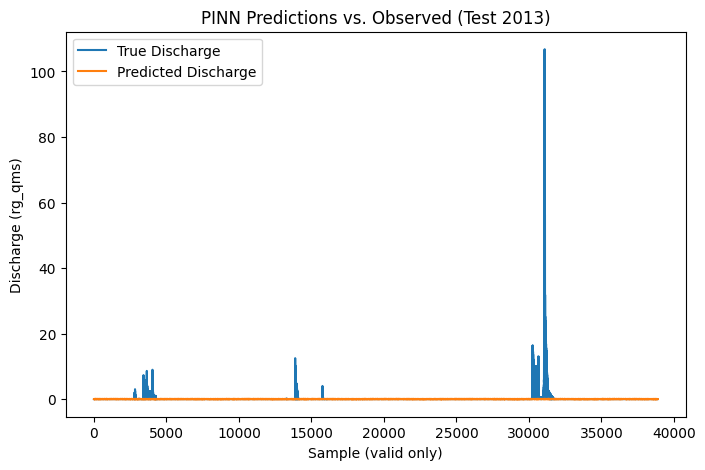

In [4]:
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

###############################################################################
# 1. LOGGING
###############################################################################
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

###############################################################################
# 2. UTILITY FUNCTIONS
###############################################################################
def log_pde_residual_statistics(residual, logger, step_label):
    with torch.no_grad():
        avg_abs_res = torch.mean(torch.abs(residual)).item()
        logger.info(f"[{step_label}] PDE residual avg: {avg_abs_res:.6f}")

###############################################################################
# 3. LOADING & PREPROCESSING
###############################################################################
def load_and_prepare_data():
    train_csv = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    test_csv  = "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"

    logger.info("Loading CSV data (2012 -> train, 2013 -> test)...")
    df_train = pd.read_csv(train_csv)
    df_test  = pd.read_csv(test_csv)

    logger.info("Converting time to datetime and numeric (seconds)...")
    df_train['time'] = pd.to_datetime(df_train['time'])
    df_test['time']  = pd.to_datetime(df_test['time'])

    t0_train = df_train['time'].min()
    df_train['time_numeric'] = (df_train['time'] - t0_train).dt.total_seconds()

    t0_test = df_test['time'].min()
    df_test['time_numeric'] = (df_test['time'] - t0_test).dt.total_seconds()

    # Fill slope with average
    mean_slope_train = df_train['slope_calculated'].mean(skipna=True)
    df_train['slope_calculated'] = df_train['slope_calculated'].fillna(mean_slope_train)

    mean_slope_test = df_test['slope_calculated'].mean(skipna=True)
    df_test['slope_calculated']  = df_test['slope_calculated'].fillna(mean_slope_test)

    # Normalize lat/lon by subtracting min
    lat_min = df_train['latitude'].min()
    lon_min = df_train['longitude'].min()
    df_train['lat_norm'] = df_train['latitude'] - lat_min
    df_train['lon_norm'] = df_train['longitude'] - lon_min

    df_test['lat_norm'] = df_test['latitude'] - lat_min
    df_test['lon_norm'] = df_test['longitude'] - lon_min

    # We'll treat lat_norm, lon_norm as the PDE inputs
    # so we won't use original lat/lon columns in the PDE

    # Split station vs collocation
    df_train_station = df_train[~df_train['rg_qms'].isna()].copy()
    df_train_colloc  = df_train[df_train['rg_qms'].isna()].copy()

    logger.info(f"Total rows in 2012 dataset: {len(df_train)}")
    logger.info(f"Station rows: {len(df_train_station)} (data loss)")
    logger.info(f"Collocation rows: {len(df_train_colloc)} (PDE loss)")

    # Filter out trivial PDE rows: we keep rows where
    # rainrate > 0.0 or slope_calculated > 1.0
    df_nontrivial = df_train_colloc[
        (df_train_colloc['rainrate'] > 0.0) | (df_train_colloc['slope_calculated'] > 1.0)
    ]

    logger.info(f"Nontrivial PDE rows: {len(df_nontrivial)}")

    # Downsample to 1%
    df_nontrivial = df_nontrivial.sample(frac=0.01, random_state=42).copy()
    logger.info(f"After downsampling: {len(df_nontrivial)} PDE rows")

    # We'll define new feature columns using lat_norm, lon_norm
    train_station_features = [
        'time_numeric', 'lat_norm', 'lon_norm', 'elevation', 'slope_calculated', 'rainrate'
    ]
    train_colloc_features = train_station_features  # same columns

    X_train_station = df_train_station[train_station_features].values
    y_train_station = df_train_station[['rg_qms']].values

    X_train_colloc = df_nontrivial[train_colloc_features].values

    # Test data (also uses lat_norm, lon_norm)
    test_features = ['time_numeric', 'lat_norm', 'lon_norm', 'elevation', 'slope_calculated', 'rainrate']
    X_test_all = df_test[test_features].values
    y_test_all = df_test[['rg_qms']].values  # can be NaN

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Torchify
    X_train_station_t = torch.tensor(X_train_station, dtype=torch.float32, requires_grad=True).to(device)
    y_train_station_t = torch.tensor(y_train_station, dtype=torch.float32).to(device)

    X_train_colloc_t  = torch.tensor(X_train_colloc,  dtype=torch.float32, requires_grad=True).to(device)
    X_test_t          = torch.tensor(X_test_all,      dtype=torch.float32, requires_grad=True).to(device)
    y_test_t          = torch.tensor(y_test_all,      dtype=torch.float32).to(device)

    # Datasets
    station_dataset = TensorDataset(X_train_station_t, y_train_station_t)
    colloc_dataset  = TensorDataset(X_train_colloc_t)

    # Single-thread, small batch
    station_loader = DataLoader(station_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
    colloc_loader  = DataLoader(colloc_dataset,  batch_size=64, shuffle=True, num_workers=0, pin_memory=False)

    return (X_train_station_t, y_train_station_t,
            X_train_colloc_t,
            X_test_t, y_test_t,
            station_loader, colloc_loader,
            device)

###############################################################################
# 4. MODEL
###############################################################################
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, in_features=6, hidden_dim=128, out_features=1, num_layers=5):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, hidden_dim))
        layers.append(SineActivation())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(SineActivation())
        
        layers.append(nn.Linear(hidden_dim, out_features))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

###############################################################################
# 5. 2D PDE RESIDUAL: partial derivatives wrt time, lat_norm, lon_norm
###############################################################################
def advanced_pde_residual(model, x, base_speed=1.0, slope_factor=0.01):
    """
    PDE: dQ/dt + wave_speed*(dQ/d(lon_norm) + dQ/d(lat_norm)) - rainrate = 0
    wave_speed = base_speed + slope_factor*slope.

    Columns:
      x[:,0] = time_numeric
      x[:,1] = lat_norm
      x[:,2] = lon_norm
      x[:,3] = elevation
      x[:,4] = slope_calculated
      x[:,5] = rainrate
    """
    time      = x[:, 0:1]
    lat_norm  = x[:, 1:2]
    lon_norm  = x[:, 2:3]
    slope     = x[:, 4:5]
    rain      = x[:, 5:6]

    Q = model(x)

    # partial derivatives
    dQ_dt = torch.autograd.grad(Q, time, grad_outputs=torch.ones_like(Q),
                                create_graph=True, retain_graph=True, allow_unused=True)[0]
    if dQ_dt is None:
        dQ_dt = torch.zeros_like(Q)

    dQ_dlat = torch.autograd.grad(Q, lat_norm, grad_outputs=torch.ones_like(Q),
                                  create_graph=True, retain_graph=True, allow_unused=True)[0]
    if dQ_dlat is None:
        dQ_dlat = torch.zeros_like(Q)

    dQ_dlon = torch.autograd.grad(Q, lon_norm, grad_outputs=torch.ones_like(Q),
                                  create_graph=True, retain_graph=True, allow_unused=True)[0]
    if dQ_dlon is None:
        dQ_dlon = torch.zeros_like(Q)

    wave_speed = base_speed + slope_factor*slope
    residual = dQ_dt + wave_speed * (dQ_dlon + dQ_dlat) - rain
    return residual

###############################################################################
# 6. TRAINING LOOP
###############################################################################
def train_pinn():
    (X_train_station_t, y_train_station_t,
     X_train_colloc_t,
     X_test_t, y_test_t,
     station_loader, colloc_loader,
     device) = load_and_prepare_data()

    model = PINN(in_features=6, hidden_dim=128, out_features=1, num_layers=5).to(device)

    logger.info("Model created. Starting training with advanced PDE...")

    mse_loss = nn.MSELoss()
    lambda_physics = 0.1
    num_epochs = 5
    num_refine = 1

    optimizer_adam = optim.Adam(model.parameters(), lr=1e-3)
    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1e-2, max_iter=100, history_size=50)

    writer = SummaryWriter(log_dir="./runs/pinn_filtered_2dpde")

    step_counter = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0

        # A) Station loop (data + PDE)
        for batch_idx, (X_st, y_st) in enumerate(station_loader):
            pred_st = model(X_st)
            loss_data = mse_loss(pred_st, y_st)

            # PDE residual
            residual_st = advanced_pde_residual(model, X_st)
            loss_pde_st = torch.mean(residual_st**2)

            loss_total = loss_data + lambda_physics * loss_pde_st
            optimizer_adam.zero_grad()
            loss_total.backward()
            optimizer_adam.step()

            running_loss += loss_total.item()
            step_counter += 1

            # Minimal logs every 100 batches
            if batch_idx % 100 == 0:
                avg_residual = torch.mean(torch.abs(residual_st)).item()
                logger.info(f"Epoch {epoch+1}/{num_epochs} Station batch {batch_idx}, "
                            f"Data loss={loss_data.item():.6f}, PDE avg res={avg_residual:.6f}, "
                            f"Total={loss_total.item():.6f}")

        # B) Collocation loop (PDE only)
        for batch_idx, (X_coll,) in enumerate(colloc_loader):
            residual_coll = advanced_pde_residual(model, X_coll)
            loss_pde_coll = torch.mean(residual_coll**2)
            loss_colloc = lambda_physics * loss_pde_coll

            optimizer_adam.zero_grad()
            loss_colloc.backward()
            optimizer_adam.step()

            running_loss += loss_colloc.item()
            step_counter += 1

            # Minimal logs every 100 colloc batches
            if batch_idx % 100 == 0:
                avg_residual = torch.mean(torch.abs(residual_coll)).item()
                logger.info(f"Epoch {epoch+1}/{num_epochs} Colloc batch {batch_idx}, "
                            f"PDE avg res={avg_residual:.6f}, PDE loss={loss_colloc.item():.6f}")

        # Evaluate on test
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test_t)
            mask_not_nan = ~torch.isnan(y_test_t)
            if mask_not_nan.sum() > 0:
                test_mse = mse_loss(pred_test[mask_not_nan], y_test_t[mask_not_nan]).item()
            else:
                test_mse = float('nan')

        epoch_time = time.time() - epoch_start
        logger.info(f"===> Epoch {epoch+1}/{num_epochs} done, "
                    f"accumulated loss={running_loss:.4f}, "
                    f"test MSE={test_mse:.4f}, time={epoch_time:.1f}s")
        writer.add_scalar("Test/MSE_Data", test_mse, epoch)

        # Checkpoint
        ckpt_path = f"pinn_checkpoint_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_adam.state_dict(),
            'loss': running_loss,
        }, ckpt_path)

    # Optional LBFGS
    def closure():
        optimizer_lbfgs.zero_grad()
        # station
        pred_st = model(X_train_station_t)
        loss_data_st = mse_loss(pred_st, y_train_station_t)

        # PDE station
        res_st = advanced_pde_residual(model, X_train_station_t)
        loss_pde_st = torch.mean(res_st**2)

        # PDE collocation
        res_coll = advanced_pde_residual(model, X_train_colloc_t)
        loss_pde_coll = torch.mean(res_coll**2)

        total_loss = loss_data_st + lambda_physics * (loss_pde_st + loss_pde_coll)
        total_loss.backward()
        return total_loss

    if num_refine > 0:
        logger.info("Starting LBFGS refinement...")
        lbfgs_start = time.time()
        model.train()
        for i in range(num_refine):
            loss_val = optimizer_lbfgs.step(closure)
            logger.info(f"LBFGS iteration {i+1}/{num_refine}, Loss={loss_val:.6f}")
        lbfgs_time = time.time() - lbfgs_start
        logger.info(f"LBFGS refinement done in {lbfgs_time:.1f}s")

    total_time = time.time() - start_time
    logger.info(f"Total training time: {total_time:.1f}s")

    writer.close()

    # Final evaluation
    logger.info("Final evaluation on 2013 test data")
    model.eval()
    with torch.no_grad():
        pred_test = model(X_test_t)
        mask_not_nan = ~torch.isnan(y_test_t)
        if mask_not_nan.sum() > 0:
            final_mse = mse_loss(pred_test[mask_not_nan], y_test_t[mask_not_nan]).item()
            final_rmse = np.sqrt(final_mse)
            ss_res = torch.sum((y_test_t[mask_not_nan] - pred_test[mask_not_nan])**2)
            ss_tot = torch.sum((y_test_t[mask_not_nan] - torch.mean(y_test_t[mask_not_nan]))**2)
            if ss_tot > 0:
                r2 = 1 - ss_res / ss_tot
            else:
                r2 = float('nan')
        else:
            final_mse  = float('nan')
            final_rmse = float('nan')
            r2         = float('nan')

    logger.info("================ FINAL TEST RESULTS (2013) ================")
    logger.info(f"Final MSE:  {final_mse:.4f}")
    logger.info(f"Final RMSE: {final_rmse:.4f}")
    if isinstance(r2, torch.Tensor):
        logger.info(f"Final R^2:  {r2.item():.4f}")
    else:
        logger.info("Final R^2:  NaN")

    torch.save(model.state_dict(), "pinn_final_model.pt")
    logger.info("Model saved as pinn_final_model.pt")

    # Optional quick plot
    valid_idx = mask_not_nan.squeeze().cpu().numpy()
    y_true = y_test_t.cpu().numpy()[valid_idx]
    y_pred = pred_test.cpu().numpy()[valid_idx]
    if len(y_true) > 0:
        plt.figure(figsize=(8,5))
        plt.plot(y_true, label='True Discharge')
        plt.plot(y_pred, label='Predicted Discharge')
        plt.title('PINN Predictions vs. Observed (Test 2013)')
        plt.xlabel('Sample (valid only)')
        plt.ylabel('Discharge (rg_qms)')
        plt.legend()
        plt.show()

###############################################################################
# 7. MAIN
###############################################################################
if __name__ == "__main__":
    train_pinn()


17:10:25 [INFO] Model created. We'll try to avoid all-zero predictions now...
17:10:33 [INFO] Epoch 1/20, Running loss=1.2580
17:10:41 [INFO] Epoch 2/20, Running loss=1.1705
17:10:48 [INFO] Epoch 3/20, Running loss=1.1557
17:10:56 [INFO] Epoch 4/20, Running loss=1.1536
17:11:04 [INFO] Epoch 5/20, Running loss=1.1507
17:11:11 [INFO] Epoch 6/20, Running loss=1.1586
17:11:19 [INFO] Epoch 7/20, Running loss=1.1500
17:11:26 [INFO] Epoch 8/20, Running loss=1.1482
17:11:34 [INFO] Epoch 9/20, Running loss=1.1488
17:11:41 [INFO] Epoch 10/20, Running loss=1.1481
17:11:49 [INFO] Epoch 11/20, Running loss=1.1492
17:11:56 [INFO] Epoch 12/20, Running loss=1.1467
17:12:04 [INFO] Epoch 13/20, Running loss=1.1474
17:12:12 [INFO] Epoch 14/20, Running loss=1.1467
17:12:20 [INFO] Epoch 15/20, Running loss=1.1456
17:12:27 [INFO] Epoch 16/20, Running loss=1.1463
17:12:35 [INFO] Epoch 17/20, Running loss=1.1457
17:12:42 [INFO] Epoch 18/20, Running loss=1.1454
17:12:50 [INFO] Epoch 19/20, Running loss=1.1445


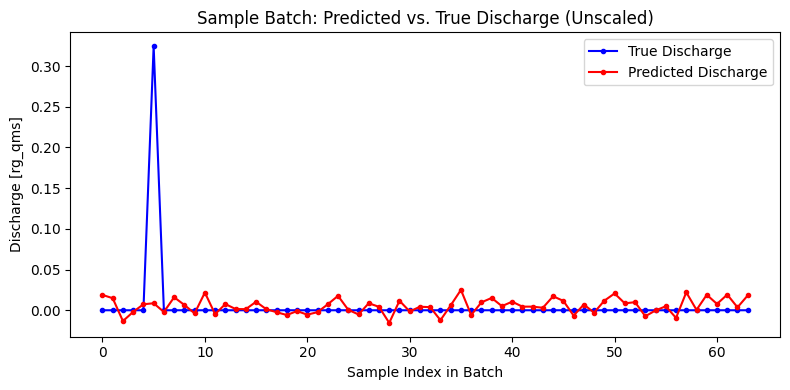

In [9]:
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

###############################################################################
# 1. LOGGING
###############################################################################
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

###############################################################################
# 2. MODEL DEFINITIONS
###############################################################################
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, in_features=6, hidden_dim=128, out_features=1, num_layers=5):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, hidden_dim))
        layers.append(SineActivation())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(SineActivation())
        
        layers.append(nn.Linear(hidden_dim, out_features))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

###############################################################################
# 3. PDE: 2D partial derivatives wrt time, lat_norm, lon_norm
###############################################################################
def advanced_pde_residual(model, x, base_speed=1.0, slope_factor=0.01):
    """
    PDE:
      dQ/dt + wave_speed*(dQ/d(lon_norm) + dQ/d(lat_norm)) - rain = 0
    wave_speed = base_speed + slope_factor*slope.

    x columns: [time_numeric, lat_norm, lon_norm, elevation, slope_calculated, rainrate]
    """
    time     = x[:, 0:1]
    lat_norm = x[:, 1:2]
    lon_norm = x[:, 2:3]
    slope    = x[:, 4:5]
    rain     = x[:, 5:6]

    Q = model(x)

    dQ_dt = torch.autograd.grad(
        Q, time,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    if dQ_dt is None:
        dQ_dt = torch.zeros_like(Q)

    dQ_dlat = torch.autograd.grad(
        Q, lat_norm,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    if dQ_dlat is None:
        dQ_dlat = torch.zeros_like(Q)

    dQ_dlon = torch.autograd.grad(
        Q, lon_norm,
        grad_outputs=torch.ones_like(Q),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
    )[0]
    if dQ_dlon is None:
        dQ_dlon = torch.zeros_like(Q)

    wave_speed = base_speed + slope_factor*slope
    residual = dQ_dt + wave_speed*(dQ_dlon + dQ_dlat) - rain
    return residual

###############################################################################
# 4. DATA LOADING & PREPROCESSING
###############################################################################
def load_and_prepare_data():
    """
    1) Loads from your real 2012 file path.
    2) Normalizes lat/lon, filters PDE rows, downsample to ~1%.
    3) Scales discharge to [0..1] by dividing by max_q.
    4) Returns station/colloc DataLoaders, device, and max_q.
    """
    # Use your exact path:
    train_csv = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    )

    if not os.path.isfile(train_csv):
        raise FileNotFoundError(f"File does not exist: {train_csv}")

    df = pd.read_csv(train_csv)
    df['time'] = pd.to_datetime(df['time'])
    t0 = df['time'].min()
    df['time_numeric'] = (df['time'] - t0).dt.total_seconds()

    # Fill slope
    slope_mean = df['slope_calculated'].mean(skipna=True)
    df['slope_calculated'] = df['slope_calculated'].fillna(slope_mean)

    # Normalize lat/lon
    lat_min = df['latitude'].min()
    lon_min = df['longitude'].min()
    df['lat_norm'] = df['latitude'] - lat_min
    df['lon_norm'] = df['longitude'] - lon_min

    # Station vs colloc
    df_station = df[~df['rg_qms'].isna()].copy()
    df_colloc  = df[df['rg_qms'].isna()].copy()

    # PDE filter
    df_colloc = df_colloc[
        (df_colloc['rainrate'] > 0.0) | (df_colloc['slope_calculated']>1.0)
    ]
    # Downsample
    df_colloc = df_colloc.sample(frac=0.01, random_state=42).copy()

    # Scale discharge by max
    max_q = df_station['rg_qms'].max()
    eps = 1e-6
    df_station['rg_qms_scaled'] = df_station['rg_qms']/(max_q + eps)

    # Feature columns
    feat_cols = ['time_numeric','lat_norm','lon_norm','elevation','slope_calculated','rainrate']

    X_station = df_station[feat_cols].values
    y_station = df_station[['rg_qms_scaled']].values

    X_colloc = df_colloc[feat_cols].values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_station_t = torch.tensor(X_station, dtype=torch.float32, requires_grad=True).to(device)
    y_station_t = torch.tensor(y_station, dtype=torch.float32).to(device)
    X_colloc_t  = torch.tensor(X_colloc, dtype=torch.float32, requires_grad=True).to(device)

    # DataLoaders
    station_ds = TensorDataset(X_station_t, y_station_t)
    station_loader = DataLoader(station_ds, batch_size=64, shuffle=True, num_workers=0)

    colloc_ds = TensorDataset(X_colloc_t)
    colloc_loader = DataLoader(colloc_ds, batch_size=64, shuffle=True, num_workers=0)

    return station_loader, colloc_loader, device, max_q

###############################################################################
# 5. QUICK PLOT FUNCTION
###############################################################################
def quick_plot_predictions(model, station_loader, max_q):
    """
    1) Grabs one batch from the station loader.
    2) Runs inference, unscales predictions & ground truth.
    3) Plots a line graph of predicted vs. actual discharge.
    """
    model.eval()
    device = next(model.parameters()).device

    # Get one batch
    X_st, y_st_scaled = next(iter(station_loader))
    X_st = X_st.to(device)
    y_st_scaled = y_st_scaled.to(device)

    with torch.no_grad():
        pred_scaled = model(X_st).squeeze()  # shape [batch]

    # Convert scaled -> real discharge
    eps = 1e-6
    pred_unscaled = pred_scaled.cpu().numpy() * (max_q + eps)
    y_true_unscaled = y_st_scaled.cpu().numpy().squeeze() * (max_q + eps)

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(y_true_unscaled, 'b.-', label='True Discharge')
    plt.plot(pred_unscaled,  'r.-', label='Predicted Discharge')
    plt.title('Sample Batch: Predicted vs. True Discharge (Unscaled)')
    plt.xlabel('Sample Index in Batch')
    plt.ylabel('Discharge [rg_qms]')
    plt.legend()
    plt.tight_layout()
    plt.show()

###############################################################################
# 6. TRAINING LOOP
###############################################################################
def train_pinn():
    station_loader, colloc_loader, device, max_q = load_and_prepare_data()

    model = PINN(in_features=6, hidden_dim=128, out_features=1, num_layers=5).to(device)
    logger.info("Model created. We'll try to avoid all-zero predictions now...")

    mse_loss = nn.MSELoss()
    lambda_pde = 0.01  # PDE weight
    num_epochs = 20

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # (A) Station loop
        for X_st, y_st in station_loader:
            pred_st = model(X_st)
            loss_data = mse_loss(pred_st, y_st)

            # PDE
            residual_st = advanced_pde_residual(model, X_st)
            loss_pde_st = torch.mean(residual_st**2)

            total_loss = loss_data + lambda_pde*loss_pde_st
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        # (B) Colloc loop
        for (X_coll,) in colloc_loader:
            residual_coll = advanced_pde_residual(model, X_coll)
            loss_pde_coll = torch.mean(residual_coll**2)
            loss_colloc = lambda_pde*loss_pde_coll

            optimizer.zero_grad()
            loss_colloc.backward()
            optimizer.step()

            running_loss += loss_colloc.item()

        logger.info(f"Epoch {epoch+1}/{num_epochs}, Running loss={running_loss:.4f}")

    # Save
    torch.save(model.state_dict(), "pinn_improved_model.pt")
    logger.info(f"Model saved as pinn_improved_model.pt (discharge scaled by max_q={max_q:.3f})")

    # Quick Plot: Check predictions on one station batch
    quick_plot_predictions(model, station_loader, max_q)

###############################################################################
# 7. MAIN
###############################################################################
if __name__ == "__main__":
    train_pinn()


17:19:29 [INFO] Model created with friction PDE to handle big flows.
17:19:38 [INFO] Epoch 1/20, Running loss=1.2743
17:19:47 [INFO] Epoch 2/20, Running loss=1.1837
17:19:56 [INFO] Epoch 3/20, Running loss=1.1707
17:20:05 [INFO] Epoch 4/20, Running loss=1.1675
17:20:15 [INFO] Epoch 5/20, Running loss=1.1671
17:20:26 [INFO] Epoch 6/20, Running loss=1.1669
17:20:36 [INFO] Epoch 7/20, Running loss=1.1624
17:20:46 [INFO] Epoch 8/20, Running loss=1.1637
17:20:55 [INFO] Epoch 9/20, Running loss=1.1640
17:21:05 [INFO] Epoch 10/20, Running loss=1.1641
17:21:15 [INFO] Epoch 11/20, Running loss=1.1663
17:21:26 [INFO] Epoch 12/20, Running loss=1.1644
17:21:36 [INFO] Epoch 13/20, Running loss=1.1636
17:21:46 [INFO] Epoch 14/20, Running loss=1.1664
17:21:56 [INFO] Epoch 15/20, Running loss=1.1644
17:22:06 [INFO] Epoch 16/20, Running loss=1.1651
17:22:15 [INFO] Epoch 17/20, Running loss=1.1670
17:22:24 [INFO] Epoch 18/20, Running loss=1.1677
17:22:34 [INFO] Epoch 19/20, Running loss=1.1661
17:22:43 

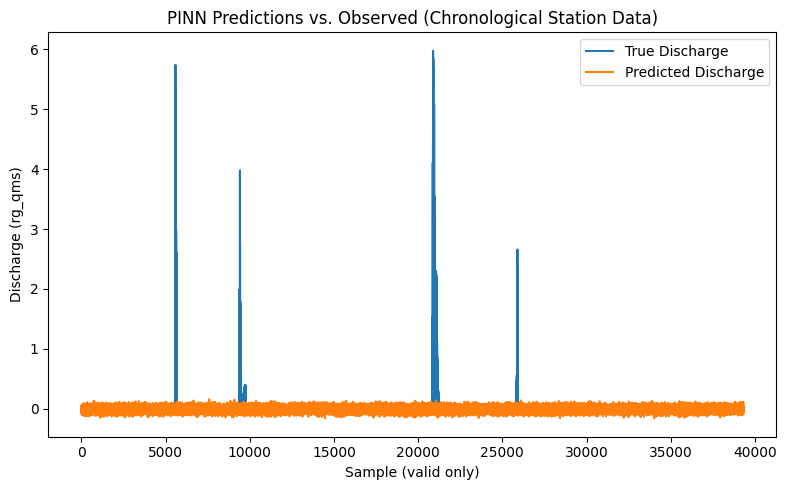

In [10]:
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

###############################################################################
# 1. LOGGING
###############################################################################
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

###############################################################################
# 2. PINN MODEL WITH SINE ACTIVATIONS
###############################################################################
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, in_features=6, hidden_dim=128, out_features=1, num_layers=5):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, hidden_dim))
        layers.append(SineActivation())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(SineActivation())
        
        layers.append(nn.Linear(hidden_dim, out_features))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

###############################################################################
# 3. PDE with SIMPLE FRICTION
###############################################################################
def pde_with_friction(model, x, base_speed=1.0, slope_factor=0.01, friction_factor=0.01):
    """
    PDE:
      dQ/dt + wave_speed * (dQ/dlon + dQ/dlat) - friction_factor * Q^2 - rain = 0
    wave_speed = base_speed + slope_factor * slope.
    Columns of x: [time_numeric, lat_norm, lon_norm, elevation, slope_calculated, rainrate]
    """
    time     = x[:, 0:1]
    lat_norm = x[:, 1:2]
    lon_norm = x[:, 2:3]
    slope    = x[:, 4:5]
    rain     = x[:, 5:6]

    Q = model(x)

    # partial derivatives
    dQ_dt = torch.autograd.grad(Q, time,
                                grad_outputs=torch.ones_like(Q),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
    if dQ_dt is None:
        dQ_dt = torch.zeros_like(Q)

    dQ_dlat = torch.autograd.grad(Q, lat_norm,
                                  grad_outputs=torch.ones_like(Q),
                                  create_graph=True, retain_graph=True,
                                  allow_unused=True)[0]
    if dQ_dlat is None:
        dQ_dlat = torch.zeros_like(Q)

    dQ_dlon = torch.autograd.grad(Q, lon_norm,
                                  grad_outputs=torch.ones_like(Q),
                                  create_graph=True, retain_graph=True,
                                  allow_unused=True)[0]
    if dQ_dlon is None:
        dQ_dlon = torch.zeros_like(Q)

    wave_speed = base_speed + slope_factor*slope

    # friction term
    friction = friction_factor * (Q**2)

    # PDE residual
    residual = dQ_dt + wave_speed*(dQ_dlon + dQ_dlat) - friction - rain
    return residual

###############################################################################
# 4. DATA LOADING & PREPROCESSING
###############################################################################
def load_and_prepare_data():
    """
    1) Use your real 2012 data path.
    2) Normalizes lat/lon, filters PDE rows, downsample, scale discharge.
    3) Also returns a DataFrame for station data so we can do a full hydrograph plot.
    """
    train_csv = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    )
    if not os.path.isfile(train_csv):
        raise FileNotFoundError(f"File does not exist: {train_csv}")

    df = pd.read_csv(train_csv)
    df['time'] = pd.to_datetime(df['time'])
    t0 = df['time'].min()
    df['time_numeric'] = (df['time'] - t0).dt.total_seconds()

    # slope fill
    slope_mean = df['slope_calculated'].mean(skipna=True)
    df['slope_calculated'] = df['slope_calculated'].fillna(slope_mean)

    lat_min = df['latitude'].min()
    lon_min = df['longitude'].min()
    df['lat_norm'] = df['latitude'] - lat_min
    df['lon_norm'] = df['longitude'] - lon_min

    # Station vs collocation
    df_station = df[~df['rg_qms'].isna()].copy()
    df_colloc  = df[df['rg_qms'].isna()].copy()

    # PDE filter
    df_colloc = df_colloc[
        (df_colloc['rainrate']>0.0) | (df_colloc['slope_calculated']>1.0)
    ]
    df_colloc = df_colloc.sample(frac=0.01, random_state=42).copy()

    # Scale discharge
    max_q = df_station['rg_qms'].max()
    eps = 1e-6
    df_station['rg_qms_scaled'] = df_station['rg_qms']/(max_q + eps)

    feat_cols = ['time_numeric','lat_norm','lon_norm','elevation','slope_calculated','rainrate']

    X_station = df_station[feat_cols].values
    y_station = df_station[['rg_qms_scaled']].values

    X_colloc = df_colloc[feat_cols].values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_station_t = torch.tensor(X_station, dtype=torch.float32, requires_grad=True).to(device)
    y_station_t = torch.tensor(y_station, dtype=torch.float32).to(device)
    X_colloc_t  = torch.tensor(X_colloc, dtype=torch.float32, requires_grad=True).to(device)

    station_ds = TensorDataset(X_station_t, y_station_t)
    station_loader = DataLoader(station_ds, batch_size=64, shuffle=True, num_workers=0)
    colloc_ds = TensorDataset(X_colloc_t)
    colloc_loader = DataLoader(colloc_ds, batch_size=64, shuffle=True, num_workers=0)

    # Return also the station DataFrame for final chronological plot
    df_station['lat_min'] = lat_min
    df_station['lon_min'] = lon_min

    return station_loader, colloc_loader, device, max_q, df_station

###############################################################################
# 5. TRAINING
###############################################################################
def train_pinn():
    station_loader, colloc_loader, device, max_q, df_station = load_and_prepare_data()

    model = PINN(in_features=6, hidden_dim=128, out_features=1, num_layers=5).to(device)
    logger.info("Model created with friction PDE to handle big flows.")

    mse_loss = nn.MSELoss()
    lambda_pde = 0.01
    friction_factor = 0.01  # tune as needed
    num_epochs = 20

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # (A) Station loop
        for X_st, y_st in station_loader:
            pred_st = model(X_st)
            loss_data = mse_loss(pred_st, y_st)

            # PDE on station batch
            res_st = pde_with_friction(model, X_st, friction_factor=friction_factor)
            loss_pde_st = torch.mean(res_st**2)

            total_loss = loss_data + lambda_pde * loss_pde_st
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        # (B) Colloc loop
        for (X_coll,) in colloc_loader:
            res_coll = pde_with_friction(model, X_coll, friction_factor=friction_factor)
            loss_pde_coll = torch.mean(res_coll**2)
            loss_colloc = lambda_pde * loss_pde_coll

            optimizer.zero_grad()
            loss_colloc.backward()
            optimizer.step()

            running_loss += loss_colloc.item()

        logger.info(f"Epoch {epoch+1}/{num_epochs}, Running loss={running_loss:.4f}")

    # Save
    torch.save(model.state_dict(), "pinn_friction_model.pt")
    logger.info(f"Saved model to pinn_friction_model.pt, max_q={max_q:.2f}")

    # Also do a final station check in chronological order
    final_station_plot(model, df_station, max_q)

###############################################################################
# 6. FINAL PLOT: FULL HYDROGRAPH
###############################################################################
def final_station_plot(model, df_station, max_q):
    """
    1) Sort df_station by time.
    2) Predict entire station dataset in chronological order.
    3) Plot actual vs. predicted discharge (unscaled).
    """
    logger.info("Plotting final station hydrograph (chronological).")

    device = next(model.parameters()).device
    model.eval()

    # Sort
    df_sorted = df_station.copy()
    df_sorted = df_sorted.sort_values(by='time')

    # Build features in the same style
    eps = 1e-6
    lat_min = df_sorted['lat_min'].iloc[0]
    lon_min = df_sorted['lon_min'].iloc[0]

    df_sorted['lat_norm'] = df_sorted['latitude'] - lat_min
    df_sorted['lon_norm'] = df_sorted['longitude'] - lon_min

    feat_cols = ['time_numeric','lat_norm','lon_norm','elevation','slope_calculated','rainrate']
    X_all = df_sorted[feat_cols].values
    X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_scaled = model(X_tensor).squeeze()  # shape [N]
        pred_unscaled = pred_scaled.cpu().numpy() * (max_q + eps)

    # The station's actual discharge
    y_true_unscaled = df_sorted['rg_qms'].values

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(y_true_unscaled, label='True Discharge')
    plt.plot(pred_unscaled, label='Predicted Discharge')
    plt.xlabel('Sample (valid only)')
    plt.ylabel('Discharge (rg_qms)')
    plt.title('PINN Predictions vs. Observed (Chronological Station Data)')
    plt.legend()
    plt.tight_layout()
    plt.show()

###############################################################################
# 7. MAIN
###############################################################################
if __name__ == "__main__":
    train_pinn()


17:22:50 [INFO] Model created. PDE includes friction to handle big flows.
17:22:59 [INFO] Epoch 1/30, Loss=1.2519
17:23:08 [INFO] Epoch 2/30, Loss=1.1765
17:23:18 [INFO] Epoch 3/30, Loss=1.1699
17:23:27 [INFO] Epoch 4/30, Loss=1.1682
17:23:36 [INFO] Epoch 5/30, Loss=1.1651
17:23:45 [INFO] Epoch 6/30, Loss=1.1644
17:23:54 [INFO] Epoch 7/30, Loss=1.1619
17:24:03 [INFO] Epoch 8/30, Loss=1.1643
17:24:12 [INFO] Epoch 9/30, Loss=1.1643
17:24:21 [INFO] Epoch 10/30, Loss=1.1693
17:24:30 [INFO] Epoch 11/30, Loss=1.1637
17:24:39 [INFO] Epoch 12/30, Loss=1.1657
17:24:48 [INFO] Epoch 13/30, Loss=1.1645
17:24:58 [INFO] Epoch 14/30, Loss=1.1630
17:25:07 [INFO] Epoch 15/30, Loss=1.1650
17:25:16 [INFO] Epoch 16/30, Loss=1.1671
17:25:25 [INFO] Epoch 17/30, Loss=1.1670
17:25:35 [INFO] Epoch 18/30, Loss=1.1681
17:25:44 [INFO] Epoch 19/30, Loss=1.1730
17:25:53 [INFO] Epoch 20/30, Loss=1.1711
17:26:02 [INFO] Epoch 21/30, Loss=1.1704
17:26:12 [INFO] Epoch 22/30, Loss=1.1708
17:26:20 [INFO] Epoch 23/30, Loss

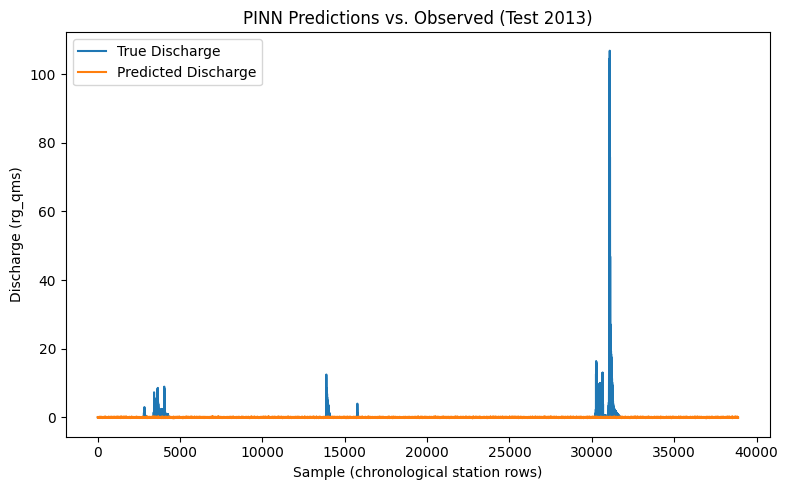

In [11]:
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

###############################################################################
# LOGGING
###############################################################################
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

###############################################################################
# 1. PINN MODEL
###############################################################################
class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class PINN(nn.Module):
    def __init__(self, in_features=6, hidden_dim=128, out_features=1, num_layers=5):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features, hidden_dim))
        layers.append(SineActivation())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(SineActivation())
        
        layers.append(nn.Linear(hidden_dim, out_features))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

###############################################################################
# 2. PDE WITH FRICTION
###############################################################################
def pde_with_friction(model, x, base_speed=1.0, slope_factor=0.01, friction_factor=0.01):
    """
    PDE: dQ/dt + wave_speed*(dQ/dlon + dQ/dlat) - friction_factor*Q^2 - rain = 0
    wave_speed = base_speed + slope_factor*slope
    x columns: [time_numeric, lat_norm, lon_norm, elevation, slope_calculated, rainrate]
    """
    time     = x[:, 0:1]
    lat_norm = x[:, 1:2]
    lon_norm = x[:, 2:3]
    slope    = x[:, 4:5]
    rain     = x[:, 5:6]

    Q = model(x)

    dQ_dt = torch.autograd.grad(Q, time, grad_outputs=torch.ones_like(Q),
                                create_graph=True, retain_graph=True,
                                allow_unused=True)[0]
    if dQ_dt is None:
        dQ_dt = torch.zeros_like(Q)

    dQ_dlat = torch.autograd.grad(Q, lat_norm, grad_outputs=torch.ones_like(Q),
                                  create_graph=True, retain_graph=True,
                                  allow_unused=True)[0]
    if dQ_dlat is None:
        dQ_dlat = torch.zeros_like(Q)

    dQ_dlon = torch.autograd.grad(Q, lon_norm, grad_outputs=torch.ones_like(Q),
                                  create_graph=True, retain_graph=True,
                                  allow_unused=True)[0]
    if dQ_dlon is None:
        dQ_dlon = torch.zeros_like(Q)

    wave_speed = base_speed + slope_factor*slope
    friction = friction_factor*(Q**2)

    residual = dQ_dt + wave_speed*(dQ_dlon + dQ_dlat) - friction - rain
    return residual

###############################################################################
# 3. LOAD + PREPROCESS 2012 (TRAIN)
###############################################################################
def load_data_2012():
    """
    Loads 2012 for training. 
    Normalizes lat/lon. 
    Filters PDE rows. 
    Scales discharge by max from 2012 station data.
    Returns station_loader, colloc_loader, device, max_q, lat_min, lon_min
    """
    train_csv_2012 = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    )
    if not os.path.isfile(train_csv_2012):
        raise FileNotFoundError(f"File not found: {train_csv_2012}")

    df = pd.read_csv(train_csv_2012)
    df['time'] = pd.to_datetime(df['time'])
    t0 = df['time'].min()
    df['time_numeric'] = (df['time'] - t0).dt.total_seconds()

    # slope fill
    slope_mean = df['slope_calculated'].mean(skipna=True)
    df['slope_calculated'] = df['slope_calculated'].fillna(slope_mean)

    lat_min = df['latitude'].min()
    lon_min = df['longitude'].min()
    df['lat_norm'] = df['latitude'] - lat_min
    df['lon_norm'] = df['longitude'] - lon_min

    df_station = df[~df['rg_qms'].isna()].copy()
    df_colloc  = df[df['rg_qms'].isna()].copy()

    # Filter PDE
    df_colloc = df_colloc[
        (df_colloc['rainrate']>0.0) | (df_colloc['slope_calculated']>1.0)
    ]
    df_colloc = df_colloc.sample(frac=0.01, random_state=42).copy()

    # Scale discharge
    max_q = df_station['rg_qms'].max()
    eps = 1e-6
    df_station['rg_qms_scaled'] = df_station['rg_qms']/(max_q + eps)

    feat_cols = ['time_numeric','lat_norm','lon_norm','elevation','slope_calculated','rainrate']

    X_st = df_station[feat_cols].values
    y_st = df_station[['rg_qms_scaled']].values
    X_coll = df_colloc[feat_cols].values

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_st_t = torch.tensor(X_st, dtype=torch.float32, requires_grad=True).to(device)
    y_st_t = torch.tensor(y_st, dtype=torch.float32).to(device)
    X_coll_t = torch.tensor(X_coll, dtype=torch.float32, requires_grad=True).to(device)

    station_ds = TensorDataset(X_st_t, y_st_t)
    station_loader = DataLoader(station_ds, batch_size=64, shuffle=True, num_workers=0)

    colloc_ds = TensorDataset(X_coll_t)
    colloc_loader = DataLoader(colloc_ds, batch_size=64, shuffle=True, num_workers=0)

    return station_loader, colloc_loader, device, max_q, lat_min, lon_min

###############################################################################
# 4. TRAIN ON 2012
###############################################################################
def train_on_2012():
    station_loader, colloc_loader, device, max_q, lat_min, lon_min = load_data_2012()

    model = PINN(in_features=6, hidden_dim=128, out_features=1, num_layers=5).to(device)
    logger.info("Model created. PDE includes friction to handle big flows.")

    mse_loss = nn.MSELoss()
    lambda_pde = 0.01
    friction_factor = 0.01
    num_epochs = 30  # more epochs for better coverage

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Station loop
        for (X_st, y_st) in station_loader:
            pred_st = model(X_st)
            loss_data = mse_loss(pred_st, y_st)

            res_st = pde_with_friction(model, X_st, friction_factor=friction_factor)
            loss_pde_st = torch.mean(res_st**2)

            total_loss = loss_data + lambda_pde*loss_pde_st
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        # Collocation loop
        for (X_coll,) in colloc_loader:
            res_coll = pde_with_friction(model, X_coll, friction_factor=friction_factor)
            loss_pde_coll = torch.mean(res_coll**2)
            loss_colloc = lambda_pde*loss_pde_coll

            optimizer.zero_grad()
            loss_colloc.backward()
            optimizer.step()

            running_loss += loss_colloc.item()

        logger.info(f"Epoch {epoch+1}/{num_epochs}, Loss={running_loss:.4f}")

    # Save
    torch.save(model.state_dict(), "pinn_friction_2012.pt")
    logger.info(f"Saved model: pinn_friction_2012.pt, max_q={max_q:.2f}")

    return model, max_q, lat_min, lon_min

###############################################################################
# 5. LOAD AND EVALUATE ON 2013
###############################################################################
def evaluate_on_2013(model, max_q, lat_min, lon_min):
    """
    1) Reads Merged_North_Dead_Sea_2013.csv
    2) Preprocesses in same style: time-> time_numeric, lat_norm=lat-lat_min, etc.
    3) For station rows (rg_qms not NaN), we predict, then unscale predictions, 
       and plot entire hydrograph in chronological order.
    """
    test_csv_2013 = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"
    )
    if not os.path.isfile(test_csv_2013):
        raise FileNotFoundError(f"File not found: {test_csv_2013}")

    df_2013 = pd.read_csv(test_csv_2013)
    df_2013['time'] = pd.to_datetime(df_2013['time'])
    t0_2013 = df_2013['time'].min()
    df_2013['time_numeric'] = (df_2013['time'] - t0_2013).dt.total_seconds()

    # fill slope
    slope_mean_2013 = df_2013['slope_calculated'].mean(skipna=True)
    df_2013['slope_calculated'] = df_2013['slope_calculated'].fillna(slope_mean_2013)

    # lat_norm, lon_norm from 2012's lat_min, lon_min
    df_2013['lat_norm'] = df_2013['latitude'] - lat_min
    df_2013['lon_norm'] = df_2013['longitude'] - lon_min

    # Station rows in 2013
    df_2013_station = df_2013[~df_2013['rg_qms'].isna()].copy()
    df_2013_station = df_2013_station.sort_values(by='time')  # chronological

    # If there are no station rows, there's nothing to plot
    if len(df_2013_station)==0:
        logger.warning("No station (rg_qms) data found in 2013 file. Nothing to plot.")
        return

    # Convert to Tensor
    feat_cols = ['time_numeric','lat_norm','lon_norm','elevation','slope_calculated','rainrate']
    X_2013_station = df_2013_station[feat_cols].values
    X_2013_station_t = torch.tensor(X_2013_station, dtype=torch.float32, requires_grad=False)

    device = next(model.parameters()).device
    X_2013_station_t = X_2013_station_t.to(device)

    # Predict scaled
    model.eval()
    with torch.no_grad():
        pred_scaled_2013 = model(X_2013_station_t).squeeze()
    # unscale
    eps = 1e-6
    pred_unscaled_2013 = pred_scaled_2013.cpu().numpy() * (max_q + eps)
    true_2013 = df_2013_station['rg_qms'].values

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(true_2013, label='True Discharge')
    plt.plot(pred_unscaled_2013, label='Predicted Discharge')
    plt.title('PINN Predictions vs. Observed (Test 2013)')
    plt.xlabel('Sample (chronological station rows)')
    plt.ylabel('Discharge (rg_qms)')
    plt.legend()
    plt.tight_layout()
    plt.show()

###############################################################################
# 6. MAIN: TRAIN ON 2012, THEN EVAL ON 2013
###############################################################################
def main():
    # 1) Train on 2012
    model, max_q, lat_min, lon_min = train_on_2012()

    # 2) Evaluate on 2013
    evaluate_on_2013(model, max_q, lat_min, lon_min)

if __name__ == "__main__":
    main()


In [12]:
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

def show_data_head(csv_path):
    """
    Reads the CSV and prints out the first 5 rows (head).
    """
    logging.info(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)
    logging.info("Data loaded. Printing head:")
    print(df.head(5))  # or any other number

if __name__ == "__main__":
    csv_path = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    )
    show_data_head(csv_path)


17:31:28 [INFO] Loading data from /media/data-ssd/PINN/DATA/model data after proccessing/full POC model/3 final files according to 'spatial PINN Hebrew'/merged/temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv...
17:31:32 [INFO] Data loaded. Printing head:


                  time  latitude  longitude  rainrate  elevation  \
0  2012-01-01 00:00:00   31.7542    35.3533       0.0  179.91008   
1  2012-01-01 00:00:00   31.7542    35.3639       0.0  182.38225   
2  2012-01-01 00:00:00   31.7542    35.3744       0.0   94.52771   
3  2012-01-01 00:00:00   31.7541    35.3850       0.0  -57.00375   
4  2012-01-01 00:00:00   31.7541    35.3956       0.0   60.18594   

   slope_calculated  rg_qms  
0               NaN     NaN  
1          2.973726     NaN  
2               NaN     NaN  
3               NaN     NaN  
4               NaN     NaN  


17:42:12 [INFO] Training data from 2013: 38808 samples, seq_len=24
17:42:12 [INFO] LSTM created. Training on 2013 station data (log(Q+1))...
17:42:12 [INFO] Epoch 1/50, Loss=0.066500
17:42:13 [INFO] Epoch 2/50, Loss=0.063877
17:42:14 [INFO] Epoch 3/50, Loss=0.064075
17:42:14 [INFO] Epoch 4/50, Loss=0.063046
17:42:15 [INFO] Epoch 5/50, Loss=0.062583
17:42:16 [INFO] Epoch 6/50, Loss=0.062782
17:42:16 [INFO] Epoch 7/50, Loss=0.061110
17:42:17 [INFO] Epoch 8/50, Loss=0.060335
17:42:18 [INFO] Epoch 9/50, Loss=0.057924
17:42:18 [INFO] Epoch 10/50, Loss=0.058795
17:42:19 [INFO] Epoch 11/50, Loss=0.056319
17:42:20 [INFO] Epoch 12/50, Loss=0.054379
17:42:20 [INFO] Epoch 13/50, Loss=0.055293
17:42:21 [INFO] Epoch 14/50, Loss=0.053568
17:42:22 [INFO] Epoch 15/50, Loss=0.051600
17:42:22 [INFO] Epoch 16/50, Loss=0.051180
17:42:23 [INFO] Epoch 17/50, Loss=0.049517
17:42:24 [INFO] Epoch 18/50, Loss=0.048894
17:42:24 [INFO] Epoch 19/50, Loss=0.053447
17:42:25 [INFO] Epoch 20/50, Loss=0.046438
17:42:26

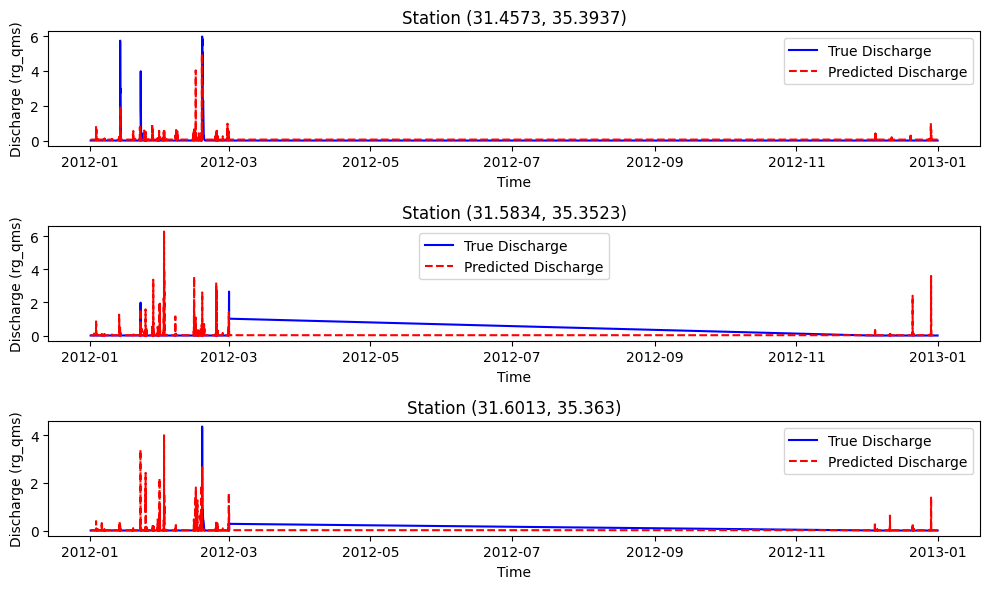

In [14]:
import os
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

###############################################################################
# LOGGING
###############################################################################
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s", datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

###############################################################################
# 1. LSTM MODEL
###############################################################################
class LSTMRegressor(nn.Module):
    """
    Predicts log(Q+1). We'll exponentiate at inference to get positive Q.
    """
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # Use last hidden state
        last_hidden = lstm_out[:, -1, :]  # shape (batch, hidden_dim)
        output = self.fc(last_hidden)     # shape (batch, 1)
        return output

###############################################################################
# 2. DATA PREPARATION
###############################################################################
def prepare_station_series(df, feature_cols, target_col='rg_qms'):
    """
    Group by station (lat, lon), keep only rows where rg_qms is not NaN.
    Return dict: station_id -> sorted DataFrame.
    """
    df_valid = df[df[target_col].notna()].copy()
    groups = df_valid.groupby(['latitude','longitude'])
    station_dict = {}
    for key, group in groups:
        group_sorted = group.sort_values(by='time')
        station_dict[key] = group_sorted.copy()
    return station_dict

def create_sliding_windows(X, y, seq_len=24):
    """
    Many-to-one approach:
      X[i : i+seq_len] -> y[i+seq_len]
    """
    X_seq, y_seq = [], []
    N = X.shape[0]
    for i in range(N - seq_len):
        X_seq.append(X[i : i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

def load_training_data_2013(seq_len=24):
    """
    Loads 2013 CSV, extracts station time series with valid rg_qms,
    uses features [rainrate, elevation, slope_calculated],
    transforms target to log(rg_qms + 1).
    Returns DataLoader for training, plus normalization stats for features.
    """
    train_csv = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2013.csv"
    )
    if not os.path.isfile(train_csv):
        raise FileNotFoundError(f"Train file not found: {train_csv}")

    df = pd.read_csv(train_csv)
    df['time'] = pd.to_datetime(df['time'])

    # Group by station
    station_dict = prepare_station_series(df, feature_cols=['rainrate','elevation','slope_calculated'],
                                          target_col='rg_qms')

    feature_cols = ['rainrate','elevation','slope_calculated']
    all_X, all_y = [], []

    for station_id, df_st in station_dict.items():
        df_st = df_st.reset_index(drop=True)
        X = df_st[feature_cols].values
        # log transform of Q
        y = np.log(df_st['rg_qms'].values + 1.0).reshape(-1,1)

        if len(X) > seq_len:
            X_seq, y_seq = create_sliding_windows(X, y, seq_len)
            all_X.append(X_seq)
            all_y.append(y_seq)

    # Combine all stations
    all_X = np.concatenate(all_X, axis=0)  # shape (N, seq_len, 3)
    all_y = np.concatenate(all_y, axis=0)  # shape (N,1)

    # Normalize input features
    X_flat = all_X.reshape(-1, all_X.shape[-1])  # shape (N*seq_len, 3)
    feat_mean = X_flat.mean(axis=0)
    feat_std  = X_flat.std(axis=0) + 1e-6
    all_X_norm = (all_X - feat_mean) / feat_std

    X_tensor = torch.tensor(all_X_norm, dtype=torch.float32)
    y_tensor = torch.tensor(all_y, dtype=torch.float32)

    ds = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=0)

    norm_params = {
        'feat_mean': feat_mean,
        'feat_std': feat_std
    }
    logger.info(f"Training data from 2013: {X_tensor.shape[0]} samples, seq_len={seq_len}")
    return loader, norm_params

def load_test_data_2012(seq_len, norm_params):
    """
    Loads 2012 CSV, extracts station rows, uses same features,
    returns a dict: station_id -> (time array, X array, y array [original scale]).
    We'll do rolling inference in evaluate_on_2012.
    """
    test_csv = (
        "/media/data-ssd/PINN/DATA/model data after proccessing/full POC model/"
        "3 final files according to 'spatial PINN Hebrew'/merged/"
        "temp_for_testing_code_dec_jan_feb/Merged_North_Dead_Sea_2012.csv"
    )
    if not os.path.isfile(test_csv):
        raise FileNotFoundError(f"Test file not found: {test_csv}")

    df = pd.read_csv(test_csv)
    df['time'] = pd.to_datetime(df['time'])
    # Keep only station rows
    df = df[df['rg_qms'].notna()].copy()
    df = df.sort_values(by='time')
    # Group by station
    groups = df.groupby(['latitude','longitude'])

    feature_cols = ['rainrate','elevation','slope_calculated']
    station_data = {}

    for station_id, group in groups:
        group = group.sort_values(by='time').reset_index(drop=True)
        time_arr = group['time'].values
        X_raw = group[feature_cols].values
        y_raw = group['rg_qms'].values  # original scale

        # Normalize X
        mean = norm_params['feat_mean']
        std  = norm_params['feat_std']
        X_norm = (X_raw - mean)/std

        station_data[station_id] = (time_arr, X_norm, y_raw)
    logger.info(f"Test data from 2012: found {len(station_data)} stations with rg_qms.")
    return station_data

###############################################################################
# 3. LSTM TRAINING
###############################################################################
def train_lstm(seq_len=24, num_epochs=50):
    train_loader, norm_params = load_training_data_2013(seq_len=seq_len)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LSTMRegressor(input_dim=3, hidden_dim=64, num_layers=1).to(device)
    logger.info("LSTM created. Training on 2013 station data (log(Q+1))...")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        for X_seq, y_seq in train_loader:
            X_seq = X_seq.to(device)  # shape (batch, seq_len, 3)
            y_seq = y_seq.to(device)  # shape (batch,1)
            pred = model(X_seq)       # predicted log(Q+1)
            loss = criterion(pred, y_seq)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = X_seq.size(0)
            running_loss += loss.item()*batch_size
            total_samples += batch_size

        epoch_loss = running_loss / total_samples
        logger.info(f"Epoch {epoch+1}/{num_epochs}, Loss={epoch_loss:.6f}")

    # Save
    save_dict = {
        'model_state': model.state_dict(),
        'norm_params': norm_params,
        'seq_len': seq_len
    }
    torch.save(save_dict, "lstm_log_2013.pt")
    logger.info("Trained model saved as lstm_log_2013.pt.")
    return model, norm_params

###############################################################################
# 4. EVALUATE ON 2012
###############################################################################
def evaluate_on_2012(model, norm_params, seq_len=24):
    """
    For each station in 2012, do a rolling prediction:
    X[t : t+seq_len] -> predict log(Q+1) at t+seq_len -> exponentiate-1 => Q
    Then compare vs. actual Q[t+seq_len].
    Plot each station's entire chronological hydrograph.
    """
    device = next(model.parameters()).device
    station_data = load_test_data_2012(seq_len, norm_params)

    model.eval()
    plt.figure(figsize=(10,6))
    n_stations = len(station_data)
    i_subplot = 1

    for station_id, (time_arr, X_norm, y_raw) in station_data.items():
        T = len(X_norm)
        if T <= seq_len:
            logger.info(f"Station {station_id} has only {T} points, skip.")
            continue

        preds = []
        times_valid = time_arr[seq_len:]  # times where we have a prediction
        # Rolling inference
        for t in range(T - seq_len):
            window = X_norm[t : t+seq_len]  # shape (seq_len, 3)
            window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_log = model(window_tensor).item()  # predicted log(Q+1)
            # Convert back to discharge
            pred_q = np.exp(pred_log) - 1.0
            if pred_q < 0:
                pred_q = 0.0  # clamp small negatives
            preds.append(pred_q)

        # The true discharge for that range
        true_q = y_raw[seq_len:]  # shape (T-seq_len,)

        # Plot
        plt.subplot(n_stations, 1, i_subplot)
        i_subplot += 1
        plt.plot(times_valid, true_q, label='True Discharge', color='b')
        plt.plot(times_valid, preds, label='Predicted Discharge', color='r', linestyle='--')
        plt.title(f"Station {station_id}")
        plt.xlabel("Time")
        plt.ylabel("Discharge (rg_qms)")
        plt.legend()
        plt.tight_layout()

    plt.show()

###############################################################################
# 5. MAIN
###############################################################################
def main():
    seq_len = 24
    # 1) Train on 2013
    model, norm_params = train_lstm(seq_len=seq_len, num_epochs=50)
    # 2) Evaluate on 2012
    evaluate_on_2012(model, norm_params, seq_len=seq_len)

if __name__ == "__main__":
    main()
